# PyTorch Image Classifier with LeNet

In [1]:
%reload_ext autoreload
%autoreload 2 
%matplotlib inline

!pip install -q bentoml "torch==1.6.0" "torchvision==0.7.0" "pillow==7.2.0"

     |████████████████████████████████| 4.0 MB 7.5 MB/s 
     |████████████████████████████████| 748.8 MB 17 kB/s 
     |████████████████████████████████| 5.9 MB 25.5 MB/s 
     |████████████████████████████████| 2.2 MB 46.0 MB/s 
     |████████████████████████████████| 63 kB 3.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.1 MB 74.5 MB/s 
     |████████████████████████████████| 131 kB 79.7 MB/s 
     |████████████████████████████████| 79 kB 9.6 MB/s 
     |████████████████████████████████| 86 kB 6.9 MB/s 
     |████████████████████████████████| 109 kB 80.7 MB/s 
     |████████████████████████████████| 131 kB 84.5 MB/s 
     |████████████████████████████████| 209 kB 75.2 MB/s 
     |████████████████████████████████| 1.3 MB 66.7 MB/s 
     |████████████████████████████████| 146 kB 81.7 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |███████

- torchvision을 사용하여 CIFAR10 훈련, 테스트 데이터 셋을 로드하고, 정규화
- CNN 정의
- loss function 정의 
- Training data로 네트워크 훈련
- Test data로 네트워크 테스트 
- BentoML로 모델 서빙

## Loading and Normalize CIFAR 10

In [13]:
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms


### transforms.Normalize
- Normalize a tensor image with mean and standard deviation.  
- output[channel] = (input[channel] - mean[channel]) / std[channel]
- parameter : mead, std, inplace(option)

In [20]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


# CIFAR10 dataset download
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=True,
                                            download=True,
                                            transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=False,
                                            download=True,
                                            transform=transform)


# DataLoader
train_loader = DataLoader(train_dataset,
                            batch_size=4,
                            shuffle=True,
                            num_workers=2)

test_loader = DataLoader(test_dataset,
                         batch_size=4,
                         shuffle=True, 
                         num_workers=2)

#.CIFAR10 classes 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img scale min: -0.9764705896377563 max: 1.0


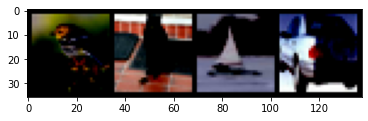

img scale min: 0.011764705181121826 max: 1.0


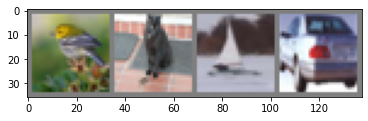

 bird   cat  ship   car


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

# scale에 따른 시각화차이를 보여주기 위함
def imshow(img):
    print(f'img scale min: {img.min()} max: {img.max()}')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    plt.close()

    img = img / 2 + 0.5     # unnormalize 
    print(f'img scale min: {img.min()} max: {img.max()}')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Defin a CNN

In [15]:
import torch.nn as nn 
import torch.nn.functional as F

In [70]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.fc3(x)
        return x

In [71]:
net = LeNet()

In [73]:
input = torch.Tensor(1, 3, 32, 32)
output = net(input)
print(output.shape)

torch.Size([1, 10])


## Define a Loss function and optimize

In [74]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [77]:
epoch_num = 1

for epoch in range(epoch_num):
    train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        output = net(inputs)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1}] loss : {train_loss / 2000:.3f}')
            train_loss = 0.0

print('Finished Training')

[1, 2000 loss : 2.220]
[1, 4000 loss : 1.866]
[1, 6000 loss : 1.669]
[1, 8000 loss : 1.569]
[1, 10000 loss : 1.516]
[1, 12000 loss : 1.449]


## Test the network on the test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img scale min: -0.9921568632125854 max: 0.929411768913269


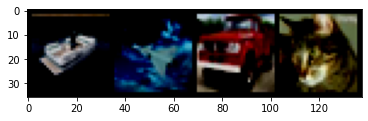

img scale min: 0.003921568393707275 max: 0.9647058844566345


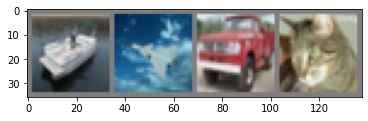

GroundTruth:   ship plane truck   cat


In [81]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [82]:
correct = 0 
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        output = net(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 48 %
